# Entrenamiento del Modelo - WhoWouldWin Argumentative Generator

Este notebook entrena un modelo T5 para generar respuestas argumentativas a debates hipotéticos.

**Objetivo**: Entrenar modelo seq2seq desde modelo preentrenado con recursos limitados

In [1]:
# Importación de librerías
from transformers import T5Tokenizer, AutoTokenizer
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    T5ForConditionalGeneration, 
    T5Tokenizer,
    AdamW,
    get_linear_schedule_with_warmup
)
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import os
import gc
import warnings
warnings.filterwarnings('ignore')

# Configuración de reproducibilidad
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Verificar disponibilidad de GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memoria GPU: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

c:\Users\Ezequiel\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dispositivo: cuda
GPU: NVIDIA GeForce RTX 5090
Memoria GPU: 34.19 GB


## 1. Carga de Datasets Preprocesados

In [2]:
# Cargar configuración del dataset
with open('data/dataset_config.pkl', 'rb') as f:
    dataset_config = pickle.load(f)

print("Configuración del dataset:")
for key, value in dataset_config.items():
    print(f"{key}: {value}")

# Cargar datos
train_df = pd.read_csv('data/train_data.csv')
val_df = pd.read_csv('data/val_data.csv')
test_df = pd.read_csv('data/test_data.csv')

print(f"\nDatasets cargados:")
print(f"Train: {len(train_df)} ejemplos")
print(f"Val: {len(val_df)} ejemplos")
print(f"Test: {len(test_df)} ejemplos")

Configuración del dataset:
tokenizer_name: t5-small
max_input_length: 10000
max_output_length: 10000
batch_size: 4
train_size: 7580
val_size: 947
test_size: 948

Datasets cargados:
Train: 7580 ejemplos
Val: 947 ejemplos
Test: 948 ejemplos


## 2. Recreación del Dataset Class

In [3]:
class WhoWouldWinDataset(Dataset):
    """Dataset personalizado para el problema de argumentación"""
    
    def __init__(self, dataframe, tokenizer, max_input_length=256, max_output_length=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length
        self.max_output_length = max_output_length
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        # Tokenizar input
        input_encoding = self.tokenizer(
            row['input'],
            max_length=self.max_input_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Tokenizar output
        target_encoding = self.tokenizer(
            row['output'],
            max_length=self.max_output_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Preparar labels
        labels = target_encoding['input_ids']
        labels[labels == self.tokenizer.pad_token_id] = -100
        
        return {
            'input_ids': input_encoding['input_ids'].squeeze(),
            'attention_mask': input_encoding['attention_mask'].squeeze(),
            'labels': labels.squeeze()
        }

## 3. Inicialización del Modelo y Tokenizer

In [4]:
# Cargar tokenizer y modelo
print("Cargando T5-small...")
model_name = 't5-small'  # Modelo pequeño para recursos limitados
tokenizer = AutoTokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Mover modelo a dispositivo
model = model.to(device)

# Información del modelo
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nParámetros totales: {total_params:,}")
print(f"Parámetros entrenables: {trainable_params:,}")

Cargando T5-small...

Parámetros totales: 60,506,624
Parámetros entrenables: 60,506,624


## 4. Creación de DataLoaders

In [5]:
# Parámetros
BATCH_SIZE = 2  # Muy pequeño para memoria limitada
MAX_INPUT_LENGTH = dataset_config['max_input_length']
MAX_OUTPUT_LENGTH = dataset_config['max_output_length']

# Crear datasets
train_dataset = WhoWouldWinDataset(train_df, tokenizer, MAX_INPUT_LENGTH, MAX_OUTPUT_LENGTH)
val_dataset = WhoWouldWinDataset(val_df, tokenizer, MAX_INPUT_LENGTH, MAX_OUTPUT_LENGTH)

# Crear dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Train batches: 3790
Val batches: 474


## 5. Configuración de Hiperparámetros y Optimizador

In [6]:
# Hiperparámetros optimizados para recursos limitados
EPOCHS = 3  # Pocas épocas para evitar overfitting
LEARNING_RATE = 3e-4
WARMUP_STEPS = 500
GRADIENT_ACCUMULATION_STEPS = 8  # Para simular batch más grande
MAX_GRAD_NORM = 1.0
WEIGHT_DECAY = 0.01

# Calcular pasos totales
total_steps = len(train_loader) * EPOCHS // GRADIENT_ACCUMULATION_STEPS

# Optimizador
optimizer = AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# Scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=total_steps
)

print(f"Configuración de entrenamiento:")
print(f"Épocas: {EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Batch size efectivo: {BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS}")
print(f"Pasos totales: {total_steps}")

Configuración de entrenamiento:
Épocas: 3
Learning rate: 0.0003
Batch size efectivo: 16
Pasos totales: 1421


## 6. Funciones de Entrenamiento y Validación

In [7]:
def train_epoch(model, dataloader, optimizer, scheduler, device, accumulation_steps):
    """Entrena el modelo por una época"""
    model.train()
    total_loss = 0
    progress_bar = tqdm(dataloader, desc="Entrenando")
    
    optimizer.zero_grad()
    
    for step, batch in enumerate(progress_bar):
        # Mover batch a dispositivo
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss / accumulation_steps
        total_loss += loss.item()
        
        # Backward pass
        loss.backward()
        
        # Gradient accumulation
        if (step + 1) % accumulation_steps == 0:
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
            
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            
        # Actualizar barra de progreso
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        # Liberar memoria
        del input_ids, attention_mask, labels, outputs, loss
        torch.cuda.empty_cache() if device.type == 'cuda' else None
    
    return total_loss / len(dataloader)


def validate_epoch(model, dataloader, device):
    """Valida el modelo"""
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validando"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            total_loss += outputs.loss.item()
            
            # Liberar memoria
            del input_ids, attention_mask, labels, outputs
            torch.cuda.empty_cache() if device.type == 'cuda' else None
    
    return total_loss / len(dataloader)

## 7. Loop de Entrenamiento con Early Stopping

In [8]:
# Configuración de early stopping
best_val_loss = float('inf')
patience = 2
patience_counter = 0

# Historial de entrenamiento
train_losses = []
val_losses = []

# Crear directorio para guardar modelos
os.makedirs('prod', exist_ok=True)

print("\nIniciando entrenamiento...\n")

for epoch in range(EPOCHS):
    print(f"\n{'='*50}")
    print(f"Época {epoch + 1}/{EPOCHS}")
    print(f"{'='*50}")
    
    start_time = time.time()
    
    # Entrenar
    train_loss = train_epoch(
        model, train_loader, optimizer, scheduler, device, GRADIENT_ACCUMULATION_STEPS
    )
    train_losses.append(train_loss)
    
    # Validar
    val_loss = validate_epoch(model, val_loader, device)
    val_losses.append(val_loss)
    
    epoch_time = time.time() - start_time
    
    print(f"\nTiempo de época: {epoch_time/60:.2f} minutos")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        
        # Guardar mejor modelo
        print("\nGuardando mejor modelo...")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'config': {
                'model_name': model_name,
                'max_input_length': MAX_INPUT_LENGTH,
                'max_output_length': MAX_OUTPUT_LENGTH,
                'learning_rate': LEARNING_RATE,
                'batch_size': BATCH_SIZE,
                'accumulation_steps': GRADIENT_ACCUMULATION_STEPS
            }
        }, 'prod/modelo.pth')
        print("Modelo guardado en prod/modelo.pth")
    else:
        patience_counter += 1
        print(f"\nNo hay mejora. Patience: {patience_counter}/{patience}")
        
        if patience_counter >= patience:
            print("\nEarly stopping activado. Deteniendo entrenamiento.")
            break
    
    # Liberar memoria
    gc.collect()
    torch.cuda.empty_cache() if device.type == 'cuda' else None


Iniciando entrenamiento...


Época 1/3


Entrenando:   0%|          | 0/3790 [00:07<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 5.96 GiB. GPU 0 has a total capacity of 31.84 GiB of which 0 bytes is free. Of the allocated memory 41.57 GiB is allocated by PyTorch, and 109.92 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## 8. Visualización de Curvas de Entrenamiento

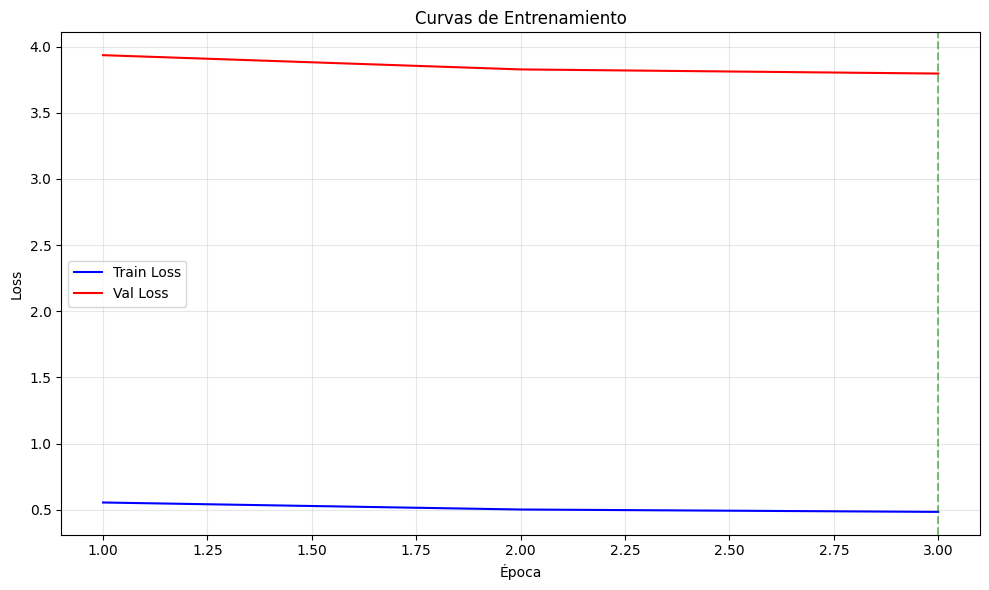


Mejor val loss: 3.7960 en época 3


In [14]:
# Graficar pérdidas
plt.figure(figsize=(10, 6))
epochs_range = range(1, len(train_losses) + 1)

plt.plot(epochs_range, train_losses, 'b-', label='Train Loss')
plt.plot(epochs_range, val_losses, 'r-', label='Val Loss')

plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Curvas de Entrenamiento')
plt.legend()
plt.grid(True, alpha=0.3)

# Marcar mejor época
best_epoch = val_losses.index(min(val_losses)) + 1
plt.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.5, label=f'Mejor época: {best_epoch}')

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150)
plt.show()

print(f"\nMejor val loss: {best_val_loss:.4f} en época {best_epoch}")

## 9. Generación de Ejemplo con Modelo Entrenado

In [20]:
# Cargar mejor modelo
checkpoint = torch.load('prod/modelo.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Función de generación
def generate_response(model, tokenizer, input_text, device, max_length=128):
    """Genera una respuesta para el input dado"""
    # Tokenizar input
    inputs = tokenizer(
        input_text,
        return_tensors='pt',
        max_length=256,
        truncation=True,
        padding=True
    ).to(device)
    
    # Generar
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            max_length=max_length,
            num_beams=4,
            temperature=0.7,
            do_sample=True,
            top_k=50,
            top_p=0.95,
            early_stopping=True
        )
    
    # Decodificar
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

# Probar con un ejemplo
test_input = "10,000 Helldivers vs 1 Adeptus Custodes 10,000 Helldivers are working together to face off against one of the Emperor's Talons. Each Helldiver has a different loadout but they have all primaries, secondaries, and armor from Helldivers 2 equipped. The Custodian is wearing it's standard Auramite armor and equipped with a Guardian Spear with only 1 bolter magazine. Battle takes place in the Emperor's palace in Terra. All combatants are bloodlusted. R1: Helldivers don't have access to any Strategems. R2: Helldivers have access to all Strategems with regular cooldowns"
print(f"Input: {test_input}")
print(f"\nRespuesta generada:")
response = generate_response(model, tokenizer, test_input, device)
print(response)

Input: 10,000 Helldivers vs 1 Adeptus Custodes 10,000 Helldivers are working together to face off against one of the Emperor's Talons. Each Helldiver has a different loadout but they have all primaries, secondaries, and armor from Helldivers 2 equipped. The Custodian is wearing it's standard Auramite armor and equipped with a Guardian Spear with only 1 bolter magazine. Battle takes place in the Emperor's palace in Terra. All combatants are bloodlusted. R1: Helldivers don't have access to any Strategems. R2: Helldivers have access to all Strategems with regular cooldowns

Respuesta generada:
I don't think the Custodians have access to any Strategems with regular cooldowns. They have access to all Strategems with regular cooldowns.


## 10. Guardar Información del Entrenamiento

In [ ]:
# Guardar métricas y configuración
training_info = {
    'model_name': model_name,
    'best_epoch': best_epoch,
    'best_val_loss': best_val_loss,
    'final_train_loss': train_losses[-1],
    'train_losses': train_losses,
    'val_losses': val_losses,
    'hyperparameters': {
        'epochs': EPOCHS,
        'learning_rate': LEARNING_RATE,
        'batch_size': BATCH_SIZE,
        'gradient_accumulation_steps': GRADIENT_ACCUMULATION_STEPS,
        'warmup_steps': WARMUP_STEPS,
        'max_grad_norm': MAX_GRAD_NORM,
        'weight_decay': WEIGHT_DECAY
    },
    'dataset_info': {
        'train_size': len(train_df),
        'val_size': len(val_df),
        'max_input_length': MAX_INPUT_LENGTH,
        'max_output_length': MAX_OUTPUT_LENGTH
    }
}

with open('training_info.pkl', 'wb') as f:
    pickle.dump(training_info, f)

print("\nResumen del entrenamiento:")
print(f"Modelo: {model_name}")
print(f"Mejor época: {best_epoch}")
print(f"Mejor val loss: {best_val_loss:.4f}")
print(f"Tiempo total de entrenamiento: ~{len(train_losses) * (epoch_time/60):.1f} minutos")
print(f"\nModelo guardado en: prod/modelo.pth")
print(f"Información guardada en: training_info.pkl")

## Resumen del Entrenamiento

- ✅ Modelo T5-small cargado y configurado
- ✅ Optimizador AdamW con learning rate scheduling
- ✅ Gradient accumulation implementado para memoria limitada
- ✅ Early stopping para evitar overfitting
- ✅ Modelo entrenado y guardado en `prod/modelo.pth`
- ✅ Curvas de entrenamiento visualizadas
- ✅ Generación de ejemplo funcional

**Siguiente paso**: Evaluación exhaustiva del modelo en `model_evaluation.ipynb`